Adjusting VGG architecture for use with MNIST dataset. Training VGG-16 from scratch.

Check the GPU assigned:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 28 11:24:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    35W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install  PyTorch
!pip install torch torchvision

In [3]:
import torch
torch.__version__

'1.8.1+cu101'

In [4]:
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time as t
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

import torch.nn as nn
#from .utils import load_state_dict_from_url
from typing import Union, List, Dict, Any, cast

## Define the model
https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html

In order to use this model on MNIST, input layer needs to accept single channel instead of 3. This is because MNIST images are single-channel (grayscale), whereas the model is set up to be used with ImageNet, which is 3-channel (RGB).

In [5]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

In [6]:
class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 10,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [7]:
cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [8]:
def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [9]:
def vgg11(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)

In [10]:
def vgg11_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)

In [11]:
def vgg13(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)

In [12]:
def vgg13_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)

In [13]:
def vgg16(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

In [14]:
def vgg16_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)

In [15]:
# select the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define the model
model = vgg16(False,True).to(device)

In [16]:
# view the details of the model
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Set variables

In [17]:
epochs = 20
batch_size = 64
learning_rate = 0.0001

## Download data
Loading MNIST data. Images need to be rescaled and numbers normalised.

In [18]:
def get_data_loaders(train_batch_size, val_batch_size):
    mnist = MNIST(download=True, train=True, root=".").train_data.float()

    data_transform = Compose([ Resize((224, 224)),ToTensor(),  Normalize(mean=(0.1307,), std=(0.3081,))])

    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=True)
    return train_loader, val_loader

In [19]:
# load the data to variables
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Run the model

In [20]:
# helper function
def calculate_metric(metric_fn, true_y, pred_y):
  # multi class problems need to have averaging methods
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  # a utility printing mfunction
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [21]:
# import datetime to include in submission
from datetime import datetime

In [22]:
# empty memory
torch.cuda.empty_cache()

In [23]:
start_ts = t.time()
now_start = datetime.now()
print(f"Starting training with {epochs} epochs on {now_start.strftime('%d/%m/%Y %H:%M:%S')}")


losses_train = []
losses_val = []
accuracies = []
times = []
# loss function, corss entropy works well for multi-class problems
loss_function = nn.CrossEntropyLoss()
# an optimiser
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    start_epoch = t.time()
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unnecessary memory in GPU 
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X) # this gets the prediction from the network
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from networks prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses_train.append(total_loss/batches) # for plotting learning curve
    losses_val.append(float((val_losses/val_batches).cpu()))
    times.append((t.time() - start_epoch)/60)
    accuracies.append(sum(accuracy)/len(accuracy))
print("Training losses:")
print(losses_train)
print("Validation losses:")
print(losses_val)
print("Accuracies:")
print(accuracies)
print()
now_end = datetime.now()
print(f"Training finished at {now_end.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Training time: {(t.time()-start_ts)/60} minutes")

Starting training with 20 epochs on 28/04/2021 11:25:04



Epoch 1/20, training loss: 0.13578078276375052, validation loss: 0.033738214522600174
	     precision: 0.9895
	        recall: 0.9888
	            F1: 0.9879
	      accuracy: 0.9892



Epoch 2/20, training loss: 0.04043323251959331, validation loss: 0.02332773245871067
	     precision: 0.9931
	        recall: 0.9928
	            F1: 0.9923
	      accuracy: 0.9926


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/20, training loss: 0.02921790721335353, validation loss: 0.024860240519046783
	     precision: 0.9915
	        recall: 0.9918
	            F1: 0.9908
	      accuracy: 0.9926



Epoch 4/20, training loss: 0.022557148898608773, validation loss: 0.02206696756184101
	     precision: 0.9937
	        recall: 0.9939
	            F1: 0.9931
	      accuracy: 0.9935



Epoch 5/20, training loss: 0.01762763066162438, validation loss: 0.02559679187834263
	     precision: 0.9926
	        recall: 0.9930
	            F1: 0.9920
	      accuracy: 0.9927



Epoch 6/20, training loss: 0.01525383439018894, validation loss: 0.013237367384135723
	     precision: 0.9962
	        recall: 0.9959
	            F1: 0.9957
	      accuracy: 0.9958



Epoch 7/20, training loss: 0.011499000797899513, validation loss: 0.016470812261104584
	     precision: 0.9946
	        recall: 0.9949
	            F1: 0.9942
	      accuracy: 0.9948


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/20, training loss: 0.010553225910352506, validation loss: 0.028463849797844887
	     precision: 0.9925
	        recall: 0.9936
	            F1: 0.9924
	      accuracy: 0.9939



Epoch 9/20, training loss: 0.009232403259623346, validation loss: 0.014167905785143375
	     precision: 0.9960
	        recall: 0.9956
	            F1: 0.9954
	      accuracy: 0.9958



Epoch 10/20, training loss: 0.007835459381724566, validation loss: 0.020890338346362114
	     precision: 0.9946
	        recall: 0.9947
	            F1: 0.9941
	      accuracy: 0.9947



Epoch 11/20, training loss: 0.00668132289247126, validation loss: 0.016677848994731903
	     precision: 0.9938
	        recall: 0.9939
	            F1: 0.9932
	      accuracy: 0.9939



Epoch 12/20, training loss: 0.006757841999435699, validation loss: 0.01871293969452381
	     precision: 0.9945
	        recall: 0.9947
	            F1: 0.9941
	      accuracy: 0.9946



Epoch 13/20, training loss: 0.0058941513028107845, validation loss: 0.023822445422410965
	     precision: 0.9938
	        recall: 0.9937
	            F1: 0.9932
	      accuracy: 0.9934



Epoch 14/20, training loss: 0.005561020038683659, validation loss: 0.030605383217334747
	     precision: 0.9901
	        recall: 0.9910
	            F1: 0.9895
	      accuracy: 0.9913



Epoch 15/20, training loss: 0.0050242102598417465, validation loss: 0.019591601565480232
	     precision: 0.9948
	        recall: 0.9950
	            F1: 0.9943
	      accuracy: 0.9950



Epoch 16/20, training loss: 0.003061253464737921, validation loss: 0.022168412804603577
	     precision: 0.9948
	        recall: 0.9937
	            F1: 0.9936
	      accuracy: 0.9945



Epoch 17/20, training loss: 0.003919608897423598, validation loss: 0.022308889776468277
	     precision: 0.9950
	        recall: 0.9948
	            F1: 0.9945
	      accuracy: 0.9952



Epoch 18/20, training loss: 0.0044794379320865834, validation loss: 0.02938087098300457
	     precision: 0.9934
	        recall: 0.9922
	            F1: 0.9919
	      accuracy: 0.9932



Epoch 19/20, training loss: 0.003923084737479584, validation loss: 0.028214657679200172
	     precision: 0.9934
	        recall: 0.9936
	            F1: 0.9928
	      accuracy: 0.9935



Epoch 20/20, training loss: 0.0032527607293191428, validation loss: 0.026614179834723473
	     precision: 0.9933
	        recall: 0.9941
	            F1: 0.9930
	      accuracy: 0.9936
Training losses:
[0.13578078276375052, 0.04043323251959331, 0.02921790721335353, 0.022557148898608773, 0.01762763066162438, 0.01525383439018894, 0.011499000797899513, 0.010553225910352506, 0.009232403259623346, 0.007835459381724566, 0.00668132289247126, 0.006757841999435699, 0.0058941513028107845, 0.005561020038683659, 0.0050242102598417465, 0.003061253464737921, 0.003919608897423598, 0.0044794379320865834, 0.003923084737479584, 0.0032527607293191428]
Validation losses:
[0.033738214522600174, 0.02332773245871067, 0.024860240519046783, 0.02206696756184101, 0.02559679187834263, 0.013237367384135723, 0.016470812261104584, 0.028463849797844887, 0.014167905785143375, 0.020890338346362114, 0.016677848994731903, 0.01871293969452381, 0.023822445422410965, 0.030605383217334747, 0.019591601565480232, 0.0221684128

Plot the training and validation loss

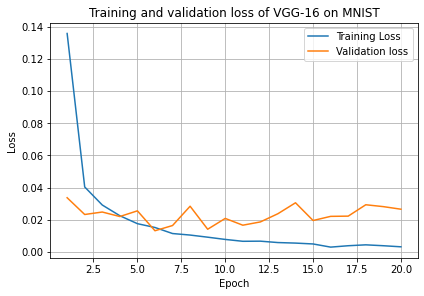

In [24]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, losses_train, label = "Training Loss")
plt.plot(x, losses_val, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Training and validation loss of VGG-16 on MNIST')
plt.savefig('Mnist_VGG16_Train.png')
plt.show()

Plot accuracy

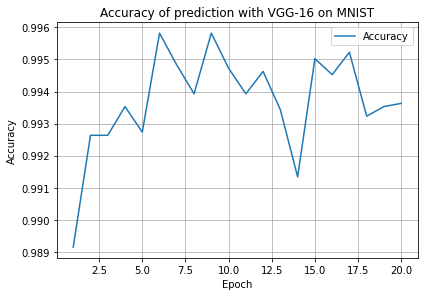

In [25]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, accuracies, label = "Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Accuracy of prediction with VGG-16 on MNIST')
plt.savefig('Mnist_VGG16_Accuracy.png')
plt.show()

Export values for loss and accuracy to a CSV file for later plotting/evaluation.

In [26]:
import pandas as pd
data = {'Data': 'MNIST', 'Model': 'VGG-16', 'Epoch': x, 'Training loss': losses_train,
     'Validation loss': losses_val, 'Accuracy': accuracies, 'Time_per_epoch': times}
df = pd.DataFrame(data)
df.to_csv('Mnist_VGG16.csv', index=False)
df

,Data,Model,Epoch,Training loss,Validation loss,Accuracy,Time_per_epoch
0,MNIST,VGG-16,1,0.135781,0.033738,0.989152,5.138318
1,MNIST,VGG-16,2,0.040433,0.023328,0.992635,5.132487
2,MNIST,VGG-16,3,0.029218,0.024860,0.992635,5.132167
3,MNIST,VGG-16,4,0.022557,0.022067,0.993531,5.118479
4,MNIST,VGG-16,5,0.017628,0.025597,0.992735,5.110838
5,MNIST,VGG-16,6,0.015254,0.013237,0.995820,5.111038
6,MNIST,VGG-16,7,0.011499,0.016471,0.994825,5.122530
7,MNIST,VGG-16,8,0.010553,0.028464,0.993929,5.123421
8,MNIST,VGG-16,9,0.009232,0.014168,0.995820,5.128936
9,MNIST,VGG-16,10,0.007835,0.020890,0.994725,5.125794
